In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.insert(
    0,
    r"C:\Users\Asus\Desktop\Repo\MasterThesis_RI\Python-Real-World-Machine-Learning\Module 2\Chapter 5",
)

import warnings

warnings.filterwarnings("ignore")

# Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modelling
# Classification
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Ranking
import lightgbm as lgb

# Semi-Supervised Learning
# import nlopt
# import CPLELearning
import SelfLearning
import scikitWQDA

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

# Balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Binning
import woeBinningPandas

# Create Unique ID
import uuid

<IPython.core.display.Javascript object>

## Data

### Synthetic Data

In [87]:
model_ds = pd.read_csv("model_ds.csv")
# Match naming conventions of Lending club data
# Accepted
df3 = model_ds[model_ds["is_accepted"] == 1]
df3 = df3.drop(["is_accepted"], axis=1)
df3 = df3.rename(columns={"y": "target"})
# Rejected
dfr = model_ds[model_ds["is_accepted"] == 0]
dfr = dfr.drop(["is_accepted"], axis=1)

# Train/Test Split (without labels)
dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())

# Shuffle the dataset
shuffle_df = dfr.sample(frac=1)

# Define a size for your train set
train_size = int(0.7 * len(shuffle_df))

# Split your dataset
dfr_dev3 = shuffle_df[:train_size]
dfr_test3 = shuffle_df[train_size:]

# Drop y
dfr_dev2 = dfr_dev3
dfr_test2 = dfr_dev3
dfr_dev3 = dfr_dev3.drop(["y"], axis=1)
dfr_test3 = dfr_test3.drop(["y"], axis=1)

<IPython.core.display.Javascript object>

In [88]:
dfr_test2 = dfr_test2[
    [
        "id",
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

In [89]:
dfr_dev2 = dfr_dev2[
    [
        "id",
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

In [90]:
dfr_dev3 = dfr_dev2[
    [
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

In [91]:
dfr_dev3 = dfr_test2[
    [
        "known_col_0",
        "known_col_1",
        "known_col_2",
        "known_col_3",
        "known_col_4",
        "known_col_5",
        "known_col_6",
        "known_col_7",
        "known_col_8",
    ]
]

<IPython.core.display.Javascript object>

### Lenidng Club Data

Data: https://www.kaggle.com/wordsforthewise/lending-club

In [ ]:
# Read data
# accepted = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)
# rejected = pd.read_csv("rejected_2007_to_2018Q4.csv", low_memory=False)

In [ ]:
# print(accepted.shape)
# print(rejected.shape)

## Preprocessing

In [ ]:
# Sample 25k obs. for easy processing
# shuffled_accepted = accepted.sample(frac=1)
# accepted_small = shuffled_accepted.sample(n=25000, random_state=7)
# accepted_small.reset_index(drop=True, inplace=True)
# accepted_small.to_csv("accepted_small")

In [ ]:
accepted_small = pd.read_csv("accepted_small")

In [ ]:
accepted_small

In [ ]:
def default_flag(x):
    if (
        x == "Charged Off"
        or x == "Does not meet the credit policy. Status:Charged Off"
        or x == "Late (16-30 days)"
        or x == "Late (31-120 days)"
        or x == "Default"
    ):
        return 1
    elif x == "Fully Paid" or x == "Does not meet the credit policy. Status:Fully Paid":
        return 0
    else:
        return 2

In [ ]:
accepted_small["target"] = accepted_small["loan_status"].apply(default_flag)

In [ ]:
# Remove Current and Missings
accepted_small = accepted_small.loc[accepted_small["target"] != 2]
accepted_small.shape

In [ ]:
pd.crosstab(accepted_small["target"], accepted_small["loan_status"])

The dataset is imbalanced

## Bucketing

In [ ]:
# Keep only 4 explanatory variables for quick and dirty PD model
df = accepted_small[
    ["id", "target", "loan_amnt", "addr_state", "emp_length", "annual_inc"]
]

In [ ]:
# Create Debt to Income and delete input variable from dataset
df["DTI"] = df["loan_amnt"] / df["annual_inc"]
del df["annual_inc"]

In [ ]:
def start_pipeline(data):
    return data.copy()

In [ ]:
def DTI_binning(x):
    if x <= 0.1:
        return "<=0.1"
    elif x > 0.1 and x <= 0.2:
        return "0.1-0.2"
    elif x > 0.2 and x <= 0.3:
        return "0.2-0.3"
    elif x > 0.3 and x <= 0.4:
        return "0.3-0.4"
    else:
        return ">0.4"

In [ ]:
# Employment Length
binning_emp_length = woeBinningPandas.woe_binning(
    df, "target", "emp_length", 0.1, 0.1, 50, 100, "bad"
)
binning_emp_length

In [ ]:
bademplen = binning_emp_length["Group_1"][:2].tolist()
nullemplen = binning_emp_length["Group_1"][2:].tolist()

In [ ]:
def empl_length_binning(x):
    if (
        x == "<1 year"
        or x == "1 year"
        or x == "2 years"
        or x == "3 years"
        or x == "4years"
        or x == "Missing"
    ):
        return "1-2 years"
    else:
        return ">2 years"

In [ ]:
def loan_amnt_binning(x):
    if x <= 1000:
        return "<=1k"
    elif x > 1000 and x <= 10000:
        return "1-10k"
    else:
        return ">10k"

In [ ]:
# State
binning = woeBinningPandas.woe_binning(
    df, "target", "addr_state", 0.1, 0.1, 50, 100, "bad"
)
binning

In [ ]:
badstates = binning["Group_1"][:25].tolist()
california = ["CA"]
goodstates = binning["Group_1"][27:].tolist()

In [ ]:
def addr_state_binning(x):
    if x == "CA":
        return "California"
    elif x in badstates:
        return "Bad state"
    else:
        return "Good state"

In [ ]:
# Function to apply the bucketing to any future dataset
def binning_function(data):
    data["loan_amnt2"] = data["loan_amnt"].apply(loan_amnt_binning)
    data["addr_state2"] = data["addr_state"].apply(addr_state_binning)
    data["emp_length2"] = data["emp_length"].apply(empl_length_binning)
    data["DTI2"] = df["DTI"].apply(DTI_binning)
    return data

In [ ]:
df2 = df.pipe(start_pipeline).pipe(binning_function)

In [ ]:
df2 = df2[["id", "target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]]

In [ ]:
# Function to explore differentiation of bucketing visually + cross tab
def diff_visual(data, variable):
    %matplotlib inline
    table = pd.crosstab(data[variable], df2["target"])
    table.div(table.sum(1).astype(float), axis=0).plot(
        kind="bar", color=["cadetblue", "crimson"], stacked=True
    )
    plt.title("Stacked Bar Loan Amount vs Default Status")
    # plt.xlabel(variable)
    plt.ylabel("Proportion of Accepts")

    x = pd.crosstab(data[variable], df2["target"]).apply(lambda r: r / r.sum(), axis=1)
    x = pd.DataFrame(x)

    y = pd.crosstab(df[variable], df["target"])
    y = pd.DataFrame(y)

    return x, y

In [ ]:
# Function to explore differentiation of bucketing visually + cross tab
def diff_visual(data, variable):
    %matplotlib inline
    table = pd.crosstab(data[variable], data["target"])
    table.div(table.sum(1).astype(float), axis=0).plot(
        kind="bar", color=["cadetblue", "crimson"], stacked=True
    )
    plt.title("Stacked Bar Loan Amount vs Default Status")
    # plt.xlabel(variable)
    plt.ylabel("Proportion of Accepts")

    x = pd.crosstab(data[variable], data["target"]).apply(lambda r: r / r.sum(), axis=1)
    x = pd.DataFrame(x)

    y = pd.crosstab(data[variable], data["target"])
    y = pd.DataFrame(y)

    return x, y

In [ ]:
diff_visual(df2, "loan_amnt2")

In [ ]:
diff_visual(df2, "emp_length2")

In [ ]:
diff_visual(df2, "addr_state2")

In [ ]:
diff_visual(df2, "DTI2")

In [ ]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]

for i in modelling_variables:
    if i != "target":
        df2 = df2.join(pd.get_dummies(df2[i]))
        df2 = df2.drop([i], axis=1)

In [ ]:
# Drop Null Band
df3 = df2.drop(columns=["1-10k", "California", ">2 years", "0.2-0.3"])

In [ ]:
X = df3.loc[:, df3.columns != "target"]
y = df3.loc[:, df3.columns == "target"]

In [ ]:
# Balance the data
os = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
columns = X_train.columns

In [ ]:
# Train
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=["target"])

# we can check the numbers of our data
print(
    "The number of observations in Development data before undersampling is ",
    len(X_train),
)
print(
    "The number of observations in Development data after undersampling is ",
    len(os_data_X),
)

In [ ]:
# Keep only columns for modelling
os_data_X_2 = os_data_X[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]
X_test_2 = X_test[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]

### FOR SYNTHETIC DATA

In [51]:
# Create X and y
X = df3.loc[:, df3.columns != "target"]
y = df3.loc[:, df3.columns == "target"]

# Train Test Split and Balance data
os = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
columns = X_train.columns

# Train
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=["target"])

# Match names with Lending Club Data
os_data_X_2 = os_data_X
X_test_2 = X_test

<IPython.core.display.Javascript object>

In [52]:
# Build Logistic regression
# Statmodels
X_in = sm.add_constant(os_data_X_2.astype(float))
logit_model = sm.Logit(os_data_y, X_in)
result3 = logit_model.fit()
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.406137
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.362     
Dependent Variable: target           AIC:              539.0435  
Date:               2020-12-31 12:44 BIC:              583.6425  
No. Observations:   639              Log-Likelihood:   -259.52   
Df Model:           9                LL-Null:          -406.73   
Df Residuals:       629              LLR p-value:      3.9782e-58
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
const        -2.0623    0.1876  -10.9930  0.0000  -2.4300  -1.6946
known_col_0  -0.2979    0.1088   -2.7380  0.0062  -0.5112  -0.

<IPython.core.display.Javascript object>

Accuracy score Logistic Regression: 0.8904761904761904


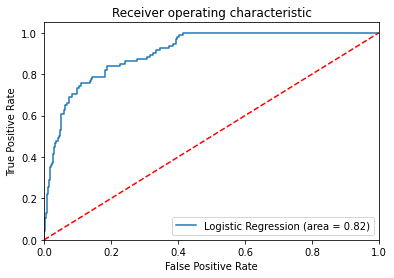

<IPython.core.display.Javascript object>

In [53]:
# Sklearn
logreg = LogisticRegression(fit_intercept=True, penalty="none")
logreg.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = logreg.predict(X_test_2)
print("Accuracy score Logistic Regression:", logreg.score(X_test_2, y_test))
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_2))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_2)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [54]:
#Test set with labels
test_labels = pd.merge(
    y_test,
    X_test,
    how="inner",
    left_index=True,
    right_index=True,
)


<IPython.core.display.Javascript object>

In [55]:
# Predictions on testset
test_pred = logreg.predict_proba(X_test_2)[:, 1]
test_pred2 = pd.DataFrame(data=test_pred, columns=["prediction"])
test_pred2["count"] = test_pred2.groupby("prediction")["prediction"].transform("count")
test_pred2.groupby(["prediction"]).count()
test_pred2.describe()

,prediction,count
count,2100.000000,2100.0
mean,0.202881,1.0
std,0.231535,0.0
min,0.000024,1.0
25%,0.031508,1.0
50%,0.106201,1.0
75%,0.298550,1.0
max,0.991097,1.0


<IPython.core.display.Javascript object>

In [56]:
# Join predictions with test new
pred_test_kgb = pd.DataFrame(
    data=test_pred, columns=["prediction_beforeRI"], index=y_test.index.copy()
)
pred_test1 = pd.merge(
    test_labels,
    pred_test_kgb[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)

# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
pred_test1

,target,known_col_0,known_col_1,known_col_2,known_col_3,known_col_4,known_col_5,known_col_6,known_col_7,known_col_8,prediction_beforeRI
7231,0,0.120288,0.595316,-1.876325,-1.032869,-0.223376,1.164968,0.482257,0.246359,0.860173,0.483956
7880,0,2.069580,0.503860,-0.198736,-0.072057,0.156990,-1.623263,0.474801,-0.026581,0.875270,0.154308
3621,0,-0.062990,-0.777283,-0.186030,0.609338,0.202800,0.963561,-0.816584,-0.621179,0.016290,0.024396
7836,0,0.448716,0.743112,0.214673,0.814224,-0.386753,1.166083,-0.622785,-0.554206,-1.009237,0.186788
7816,0,0.188821,0.944693,-1.229423,0.483918,-1.064125,2.208808,0.786099,-0.210297,0.294476,0.350769
...,...,...,...,...,...,...,...,...,...,...,...
5796,0,0.137725,-0.655189,0.259445,0.826849,0.663798,0.222962,0.091939,0.113713,0.880674,0.028352
1128,0,-0.020695,-1.029771,-1.882774,-0.890091,0.517958,0.861856,-1.054173,-1.904468,-0.201315,0.044963
3617,0,-0.308260,1.000664,0.484986,1.590688,-0.059050,0.992015,-0.816889,-1.768316,0.026157,0.238189
8491,0,-1.158329,-1.836229,2.523833,-0.061446,-0.130475,0.781090,0.590055,-0.343272,0.356698,0.004867


<IPython.core.display.Javascript object>

In [57]:
# pred_test1.shape  # Expected nr. of observations

<IPython.core.display.Javascript object>

### Random Forest

In [58]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = rf.predict(X_test_2)
print("Accuracy score Random Forest:", rf.score(X_test_2, y_test))
print("F1 score Random Forest:", f1_score(y_pred, y_test, average="weighted"))

Accuracy score Random Forest: 0.9014285714285715
F1 score Random Forest: 0.882697879203723


<IPython.core.display.Javascript object>

### Decision Tree

In [59]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = dt.predict(X_test_2)
print("Accuracy score Decision Tree:", dt.score(X_test_2, y_test))
print("F1 score Decision Tree", f1_score(y_pred, y_test, average="weighted"))

Accuracy score Decision Tree: 0.7961904761904762
F1 score Decision Tree 0.7400829647800345


<IPython.core.display.Javascript object>

In [60]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1668, 1: 432}

<IPython.core.display.Javascript object>

### SVM

In [61]:
svm = svm.SVC()
svm.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = svm.predict(X_test_2)
print("Accuracy score SVM:", svm.score(X_test_2, y_test))
print("F1 score SVM:", f1_score(y_pred, y_test, average="weighted"))

AttributeError: 'SVC' object has no attribute 'SVC'

<IPython.core.display.Javascript object>

### K-Means

In [62]:
km = KMeans(n_clusters=2)
km.fit(os_data_X_2, os_data_y.values.ravel())
y_pred = km.predict(X_test_2)

<IPython.core.display.Javascript object>

### Hierarchical clustering

In [63]:
hc = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
hc.fit_predict(os_data_X_2, os_data_y.values.ravel())
y_pred = km.predict(X_test_2)

<IPython.core.display.Javascript object>

### Light GBM Ranker

In [64]:
X_train_GBM, X_val, y_train_GBM, y_val = train_test_split(
    os_data_X_2, os_data_y, test_size=0.2, random_state=1
)

<IPython.core.display.Javascript object>

In [65]:
gbm = lgb.LGBMRanker()

query_train = [X_train_GBM.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test_2.shape[0]]

gbm.fit(
    X_train_GBM,
    y_train_GBM,
    group=query_train,
    eval_set=[(X_val, y_val)],
    eval_group=[query_val],
    eval_at=[5, 10, 20],
    early_stopping_rounds=50,
)

y_pred = gbm.predict(X_test_2)

[1]	valid_0's ndcg@5: 0.853932	valid_0's ndcg@10: 0.905212	valid_0's ndcg@20: 0.866867
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 0.930569	valid_0's ndcg@20: 0.889416
[3]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.927514
[4]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.928178
[5]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.965937
[6]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.965937
[7]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.965937
[8]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.965937
[9]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.96449
[10]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.96449
[11]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.96449
[12]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 0.963644
[13]	valid_0's ndcg@5: 1	valid_0's ndcg@10

<IPython.core.display.Javascript object>

In [66]:
X_test_2["prediction_beforeRI"] = test_pred
X_test_2.sort_values("prediction_beforeRI", ascending=False)

,known_col_0,known_col_1,known_col_2,known_col_3,known_col_4,known_col_5,known_col_6,known_col_7,known_col_8,prediction_beforeRI
9648,-1.376924,2.638756,-1.816332,-2.550811,-0.645050,0.894726,0.471508,1.973001,-1.501380,0.991097
1595,-1.923012,2.688573,0.016730,-0.950701,0.332375,0.960318,0.624541,-1.106497,1.160781,0.984219
8192,-0.573999,3.189136,-1.079263,-0.923375,-1.638883,-1.994466,-0.288762,0.471544,0.879242,0.982892
7028,-0.683603,2.430056,0.184375,-1.087961,0.631205,1.033674,1.233967,0.387847,0.019349,0.968569
2462,-1.537024,2.180000,-1.209865,-1.637061,-0.440436,0.355379,-2.410618,-2.509511,1.038530,0.963888
...,...,...,...,...,...,...,...,...,...,...
7773,0.289924,-3.031079,-0.880715,0.382012,-0.497031,0.621470,-0.886408,-0.728891,1.450808,0.000421
9431,1.650316,-2.459913,-0.183394,1.090615,-1.389713,1.495926,0.038896,0.171455,-1.272024,0.000348
8295,-1.582314,-3.711331,-1.710281,0.076296,0.311418,0.022028,-1.044499,0.453558,-1.014012,0.000301
4980,-0.596218,-3.539279,-0.531326,1.554941,-0.030173,-0.597219,0.070082,0.088768,-1.333998,0.000096


<IPython.core.display.Javascript object>

(array([1018.,  357.,  195.,  146.,  108.,   81.,   64.,   61.,   35.,
          35.]),
 array([2.42464426e-05, 9.91314921e-02, 1.98238738e-01, 2.97345983e-01,
        3.96453229e-01, 4.95560475e-01, 5.94667720e-01, 6.93774966e-01,
        7.92882212e-01, 8.91989457e-01, 9.91096703e-01]),
 <a list of 10 Patch objects>)

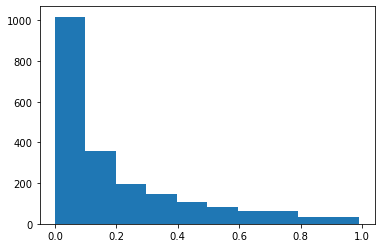

<IPython.core.display.Javascript object>

In [32]:
plt.hist(X_test_2["prediction_beforeRI"], bins=10)

In [33]:
df = df[["target", "loan_amnt", "DTI"]]

NameError: name 'df' is not defined

<IPython.core.display.Javascript object>

In [ ]:
ok = df[["target", "loan_amnt", "DTI"]]

## Apply the KGB Model to the Rejects

In [ ]:
# Sampling
# rejected_shuffled = rejected.sample(frac=1)
# rejected_small = rejected_shuffled.sample(n=10000, random_state=7)
# rejected_small.reset_index(drop=True, inplace=True)
# rejected_small.to_csv("rejected_small")

In [67]:
rejected_small = pd.read_csv("rejected_small")
rejected_small.rename(columns={"Amount Requested": "loan_amnt"}, inplace=True)
rejected_small.rename(columns={"Employment Length": "emp_length_new"}, inplace=True)
rejected_small.rename(columns={"State": "addr_state"}, inplace=True)
rejected_small.rename(columns={"Debt-To-Income Ratio": "DTI"}, inplace=True)
rejected_small["DTI"] = pd.to_numeric(rejected_small["DTI"].str[:-1])
dfr = rejected_small[["loan_amnt", "addr_state", "emp_length_new", "DTI"]]

<IPython.core.display.Javascript object>

In [68]:
# Create unique id for the rejects (to facilitate merge later)
dfr["id"] = dfr.index.to_series().map(lambda x: uuid.uuid4())

<IPython.core.display.Javascript object>

In [ ]:
# Map values of emp. length of accepts to the rejects
dfr["emp_length"] = dfr["emp_length_new"].apply(
    lambda x: "1 year"  # match name
    if (
        x == "1 year"
        or x == "< 1 year"
        or x == "2 years"
        or x == "3 years"
        or x == "4 years"
    )
    else "8 years"
)
del dfr["emp_length_new"]

In [ ]:
# Train/Test Split (without labels)

# Shuffle the dataset
shuffle_df = dfr.sample(frac=1)

# Define a size for your train set
train_size = int(0.7 * len(shuffle_df))

# Split your dataset
dfr_dev = shuffle_df[:train_size]
dfr_test = shuffle_df[train_size:]

In [ ]:
# Bucketing Train set (based on the custom function)
dfr_dev = dfr_dev.pipe(start_pipeline).pipe(binning_function)

In [ ]:
dfr_dev = dfr_dev[["id", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]]

In [ ]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]

for i in modelling_variables:
    if i != "target":
        dfr_dev = dfr_dev.join(pd.get_dummies(dfr_dev[i]))
        dfr_dev = dfr_dev.drop([i], axis=1)

In [ ]:
# Drop Null Band
dfr_dev2 = dfr_dev.drop(columns=["1-10k", "California", ">2 years", "0.2-0.3"])

In [ ]:
dfr_dev.head(100)

In [ ]:
# Bucketing (based on a custom function)
dfr_test = dfr_test.pipe(start_pipeline).pipe(binning_function)

In [ ]:
# One hot encoding
modelling_variables = ["target", "loan_amnt2", "addr_state2", "emp_length2", "DTI2"]

for i in modelling_variables:
    if i != "target":
        dfr_test = dfr_test.join(pd.get_dummies(dfr_test[i]))
        dfr_test = dfr_test.drop([i], axis=1)

In [ ]:
# Drop Null Band
dfr_test2 = dfr_test.drop(
    columns=[
        "loan_amnt",
        "addr_state",
        "emp_length",
        "1-10k",
        "California",
        ">2 years",
        "0.2-0.3",
    ]
)

In [ ]:
dfr_dev3 = dfr_dev2[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]
dfr_test3 = dfr_test2[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]

### Function for predictions

Predictions1 uses predict_proba; predictions 2 uses predict

In [69]:
def predictions1(model, treshold):
    # Join predictions with train new
    pred = model.predict_proba(dfr_dev3)[:, 1]
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

In [81]:
def predictions2(model, treshold):
    # Join predictions with train new
    pred = model.predict(dfr_dev3)
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

In [82]:
def predictions1(model, treshold):
    # Join predictions with train new
    pred = model.predict_proba(dfr_dev3)[:, 1]
    pred2 = pd.DataFrame(
        data=pred,
        columns=["prediction2"],
        index=dfr_dev2.index.copy(),
    )
    pred2["prediction_beforeRI"] = pred2["prediction2"].apply(
        lambda x: 0 if (x < treshold) else 1
    )
    outcome = pd.merge(
        dfr_dev2,
        pred2[["prediction_beforeRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    outcome = outcome[["id", "prediction_beforeRI"]]
    return outcome

<IPython.core.display.Javascript object>

### Predictions

In [83]:
ri1_train = predictions1(logreg, 0.3)  # Logistic Regression
ri2_train = predictions1(dt, 0.3)  # Decision Tree
ri3_train = predictions1(rf, 0.3)  # Random Forest
ri4_train = predictions2(svm, 0.3)  # SVM
ri5_train = predictions2(km, 0.3)  # K-means on Accepts
ri8_train = predictions2(gbm, 0.2)  # Light GBM ranking 0.2
ri9_train = predictions2(gbm, 0.1)  # Light GBM ranking 0.1

TypeError: float() argument must be a string or a number, not 'UUID'

<IPython.core.display.Javascript object>

### K-Means

to-do:
- grid search/hypterparameter optimization
- visualization

In [ ]:
kmeans = KMeans(
    init="random", n_clusters=2, n_init=10, max_iter=300, random_state=7
).fit(dfr_dev3)

In [ ]:
print("Inertia: ", kmeans.inertia_)
print("Cluster centers: ", kmeans.cluster_centers_)
print("N iter: ", kmeans.n_iter_)
print("Labels: ", kmeans.labels_)

### Reject Inference K-means

### Train set

In [ ]:
# Predictions
rej_test_predictions_kmeans = kmeans.labels_
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()

In [ ]:
# Join predictions with train new
pred_ri = kmeans.labels_
pred_ri2 = pd.DataFrame(
    data=pred_ri, columns=["prediction_beforeRI"], index=dfr_dev2.index.copy()
)
ri6 = pd.merge(
    dfr_dev2,
    pred_ri2[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri6_train = ri6[["id", "prediction_beforeRI"]]
ri6_train

### Test Set

In [ ]:
# Predictions
rej_test_predictions_kmeans2 = kmeans.predict(dfr_test3)
df_pred_rej_kmeans2 = pd.DataFrame(
    data=rej_test_predictions_kmeans2,
    columns=["prediction"],
    index=dfr_test2.index.copy(),
)
df_pred_rej_kmeans2["Rejects"] = df_pred_rej_kmeans2.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans2.groupby(["prediction"]).count()

In [ ]:
# Join predictions with test new
pred_test_ri = kmeans.predict(dfr_test3)
pred_test_ri6 = pd.DataFrame(
    data=pred_test_ri, columns=["prediction_beforeRI"], index=dfr_test2.index.copy()
)
ri6_testing = pd.merge(
    dfr_test2,
    pred_test_ri6[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri6_test = ri6_testing[["id", "prediction_beforeRI"]]
ri6_test

In [ ]:
# Check correlations
ri6_testing[ri6_testing.columns[1:]].corr()["prediction_beforeRI"][:]

### Hierarchical Clustering

In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="ward")
cluster.fit_predict(dfr_dev3)

In [ ]:
# Predictions
rej_test_predictions_aggl = cluster.labels_
df_pred_rej_aggl = pd.DataFrame(data=rej_test_predictions_aggl, columns=["prediction"])
df_pred_rej_aggl["Rejects"] = df_pred_rej_aggl.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_aggl.groupby(["prediction"]).count()

In [ ]:
# Join predictions with train new
pred_ri_aggl = cluster.labels_
pred_ri_aggl2 = pd.DataFrame(
    data=pred_ri_aggl,
    columns=["prediction_beforeRI"],
    index=dfr_dev2.index.copy(),
)
ri7 = pd.merge(
    dfr_dev2,
    pred_ri_aggl2[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri7_train = ri7[["id", "prediction_beforeRI"]]
ri7_train

In [ ]:
# Check correlations
ri7[ri7.columns[1:]].corr()["prediction_beforeRI"][:]

### Reject Inference Semi-Supervised Learning

### Label Propagation

In [ ]:
from sklearn.semi_supervised import LabelPropagation

In [ ]:
ri10_train = ri9_train.copy()
ri10_train

In [ ]:
def ssl(ri_data):  # ri1_train, ri2_train, etc..

    # TRAIN NEW
    # Join labels to train set
    # Accepts
    train_accepts = pd.merge(
        os_data_X, os_data_y[["target"]], how="left", left_index=True, right_index=True
    )

    train_accepts["Flag1"] = "Accept"

    # Rejects
    train_rejects = pd.merge(
        dfr_dev2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    train_accepts.dropna(subset=["target"], inplace=True)
    train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

    # Concatenate Train Accepts and Train Rejects
    train_new = pd.concat([train_accepts, train_rejects])

    # Flag
    train_new["Flag"] = train_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )
    train_new = train_new.drop(columns=["Flag1", "<=1k", ">10k"])
    return train_new

In [ ]:
def unlabel_rejects(df):
    df["target_new"] = "-1"
    ri10_train2["target_new"][
        (ri10_train2["Flag"] == "Accept") & (ri10_train2["target"] == 1)
    ] = 1
    ri10_train2["target_new"][
        (ri10_train2["Flag"] == "Accept") & (ri10_train2["target"] == 0)
    ] = 0
    df = df.drop(["target", "Flag"], axis=1)
    df = df.rename(columns={"target_new": "target"})
    return df

In [ ]:
ri10_train3 = unlabel_rejects(ri10_train2)

In [ ]:
label_prop_model = LabelPropagation()
data = np.copy(
    ri10_train3[
        ["Bad state", "Good state", "1-2 years", "0.1-0.2", "0.3-0.4", "<=0.1", ">0.4"]
    ]
)
labels = np.copy(ri10_train3["target"])
label_prop_model.fit(data, labels)

In [ ]:
label_prop_model = LabelPropagation()
iris = datasets.load_iris()
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(iris.target)) < 0.3
labels = np.copy(iris.target)
labels[random_unlabeled_points] = -1  # assings -1 to the unlabelled points


### Evaluation Measures

In [ ]:
def print_results(data, state, prediction):
    print(
        "The number of accurately classified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 1)
            | (data.target == 0) & (data[prediction] == 0)
        ].shape[0],
    )
    print(
        "The number of misclassified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 0)
            | (data.target == 0) & (data[prediction] == 1)
        ].shape[0],
    )

In [ ]:
def evaluation(ri_data):  # ri1_train, ri2_train, etc..

    # TRAIN NEW
    # Join labels to train set
    # Accepts
    train_accepts = pd.merge(
        os_data_X, os_data_y[["target"]], how="left", left_index=True, right_index=True
    )

    train_accepts["Flag1"] = "Accept"

    # Rejects
    train_rejects = pd.merge(
        dfr_dev2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    train_accepts.dropna(subset=["target"], inplace=True)
    train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

    # Concatenate Train Accepts and Train Rejects
    train_new = pd.concat([train_accepts, train_rejects])

    # Flag
    train_new["Flag"] = train_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )
    train_new = train_new.drop(columns=["Flag1", "<=1k", ">10k"])

    # Retrain KGB Model

    # Split
    X_new = train_new.loc[:, train_new.columns != "target"]
    X_new = X_new.loc[:, X_new.columns != "Flag"]
    y_new = train_new.loc[:, train_new.columns == "target"]
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_new, y_new, test_size=0.3, random_state=7
    )

    # Keep only columns for modelling
    os_data_X_2_new = X_train_new[
        [
            "Good state",
            "Bad state",
            "1-2 years",
            "<=0.1",
            "0.1-0.2",
            "0.3-0.4",
            ">0.4",
        ]
    ]
    X_test_2_new = X_test_new[
        [
            "Good state",
            "Bad state",
            "1-2 years",
            "<=0.1",
            "0.1-0.2",
            "0.3-0.4",
            ">0.4",
        ]
    ]

    # Build Logistic regression
    logreg = LogisticRegression(fit_intercept=False, penalty="none")
    logreg.fit(os_data_X_2_new, y_train_new.values.ravel())

    # TEST NEW
    # Join labels to test set
    # Accepts
    test_accepts = pd.merge(
        X_test, y_test[["target"]], how="left", left_index=True, right_index=True
    )

    test_accepts["Flag1"] = "Accept"

    # Rejects
    test_rejects = pd.merge(
        dfr_test2,
        ri_data[["prediction_beforeRI"]],
        how="left",
        left_index=True,
        right_index=True,
    )

    # Drop Null values and align naming
    test_accepts.dropna(subset=["target"], inplace=True)
    test_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)
    test_rejects.dropna(subset=["target"], inplace=True)

    # Concatenate Test Accepts and Test Rejects
    test_new = pd.concat([test_accepts, test_rejects])

    # Flag
    test_new["Flag"] = test_new["Flag1"].apply(
        lambda x: "Accept" if x == "Accept" else "Reject"
    )

    test_new = test_new.drop(columns=["DTI", "Flag1", "<=1k", ">10k"])

    test_new = test_new.reset_index(drop=True)

    X_test_new = test_new.loc[:, test_new.columns != "target"]
    X_test_new2 = X_test_new.loc[:, X_test_new.columns != "Flag"]
    X_test_new3 = X_test_new2.loc[:, X_test_new2.columns != "id"]
    X_test_new4 = X_test_new3.loc[:, X_test_new3.columns != ">10k"]
    y_test_new = test_new.loc[:, test_new.columns == "target"]

    # PREDICTIONS
    # Join predictions with test new
    test_new_pred = logreg.predict_proba(X_test_new4)[:, 1]
    pred_test_df = pd.DataFrame(
        data=test_new_pred, columns=["prediction_afterRI"], index=test_new.index.copy()
    )
    pred_test = pd.merge(
        test_new,
        pred_test_df[["prediction_afterRI"]],
        how="inner",
        left_index=True,
        right_index=True,
    )
    # pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
    pred_test

    a1 = pred_test1[["id", "target", "prediction_beforeRI"]]
    a2 = pred_test[["id", "Flag", "prediction_afterRI"]]

    # Join (outer to get full sample)
    a1_a2_outer = pd.merge(a1, a2, how="outer", on="id")
    # Join (inner to get only accepts and be able to compare)
    a1_a2_inner = pd.merge(a1, a2, how="inner", on="id")
    a1_a2_inner

    # Make binary predictions based on cutoff 0.3
    a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner[
        "prediction_beforeRI"
    ].apply(lambda x: 0 if (x < 0.3) else 1)
    a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
        lambda x: 0 if (x < 0.3) else 1
    )

    print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
    print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")

In [ ]:
evaluation(ri1_train)  # Simple Augmentation - Log Reg

In [ ]:
evaluation(ri2_train)  # Decision Tree

In [ ]:
evaluation(ri3_train)  # Random Forest

In [ ]:
evaluation(ri4_train)  # SVM

In [ ]:
evaluation(ri5_train)  # K-Means on Accepts

In [ ]:
evaluation(ri6_train)  # K-Means on Rejects

In [ ]:
evaluation(ri7_train)  # Hierarchical clustering on Rejects

In [ ]:
evaluation(ri8_train)  # LightGBM Ranking (treshold 0.2)

In [ ]:
evaluation(ri9_train)  # LightGBM Ranking (treshold 0.1)

## **DON'T RUN AFTER HERE**

### Predictions: Logistic Regression

In [ ]:
# Predictions
rej_test_predictions = logreg.predict_proba(dfr_dev3)[:, 1]
df_pred_rej = pd.DataFrame(
    data=rej_test_predictions,
    columns=["prediction_beforeRI"],
    index=dfr_dev2.index.copy(),
)
df_pred_rej["Rejects"] = df_pred_rej.groupby("prediction_beforeRI")[
    "prediction_beforeRI"
].transform("count")
df_pred_rej.groupby(["prediction_beforeRI"]).count()

### Reject Inference: Simple Augmentation (arbitrary cutoff 0.3)

In [ ]:
# Join predictions with train new
pred_ri = logreg.predict_proba(dfr_dev3)[:, 1]
pred_ri1 = pd.DataFrame(
    data=pred_ri,
    columns=["prediction2"],
    index=dfr_dev2.index.copy(),
)
pred_ri1["prediction_beforeRI"] = pred_ri1["prediction2"].apply(
    lambda x: 0 if (x < 0.3) else 1
)
ri1 = pd.merge(
    dfr_dev2,
    pred_ri1[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri1_train = ri1[["id", "prediction_beforeRI"]]
ri1_train

### Predictions: Random Forest

In [ ]:
# Join predictions with train new
pred_rf_ri = clf.predict_proba(dfr_dev3)[:, 1]
pred_rf_ri1 = pd.DataFrame(
    data=pred_rf_ri,
    columns=["prediction2"],
    index=dfr_dev2.index.copy(),
)
pred_rf_ri1["prediction_beforeRI"] = pred_rf_ri1["prediction2"].apply(
    lambda x: 0 if (x < 0.3) else 1
)
ri4 = pd.merge(
    dfr_dev2,
    pred_rf_ri1[["prediction_beforeRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
ri4_train = ri4[["id", "prediction_beforeRI"]]
ri4_train

#### Prepare Train New

In [ ]:
# Join labels to train set
# Accepts
train_accepts = pd.merge(
    os_data_X, os_data_y[["target"]], how="left", left_index=True, right_index=True
)

train_accepts["Flag1"] = "Accept"

# Rejects
train_rejects = pd.merge(
    dfr_dev2,
    ri2_train[["prediction_beforeRI"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Drop Null values and align naming
train_accepts.dropna(subset=["target"], inplace=True)
train_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)

In [ ]:
# Concatenate Train Accepts and Train Rejects
train_new = pd.concat([train_accepts, train_rejects])

In [ ]:
train_new.shape  # As expected

In [ ]:
# Flag
train_new["Flag"] = train_new["Flag1"].apply(
    lambda x: "Accept" if x == "Accept" else "Reject"
)
train_new = train_new.drop(columns=["Flag1", "DTI", "<=1k", ">10k"])

In [ ]:
train_new

In [ ]:
# Retrain KGB Model

# Split
X_new = train_new.loc[:, train_new.columns != "target"]
X_new = X_new.loc[:, X_new.columns != "Flag"]
y_new = train_new.loc[:, train_new.columns == "target"]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.3, random_state=7
)

# Keep only columns for modelling
os_data_X_2_new = X_train_new[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]
X_test_2_new = X_test_new[
    [
        "Good state",
        "Bad state",
        "1-2 years",
        "<=0.1",
        "0.1-0.2",
        "0.3-0.4",
        ">0.4",
    ]
]

# Build Logistic regression
logreg = LogisticRegression(fit_intercept=False, penalty="none")
logreg.fit(os_data_X_2_new, y_train_new.values.ravel())

#### Prepare Test New

In [ ]:
# Join labels to test set
# Accepts
test_accepts = pd.merge(
    X_test, y_test[["target"]], how="left", left_index=True, right_index=True
)

test_accepts["Flag1"] = "Accept"

# Rejects
test_rejects = pd.merge(
    dfr_test2,
    ri2_test[["prediction_beforeRI"]],
    how="left",
    left_index=True,
    right_index=True,
)

# Drop Null values and align naming
test_accepts.dropna(subset=["target"], inplace=True)
test_rejects.rename(columns={"prediction_beforeRI": "target"}, inplace=True)
test_rejects.dropna(subset=["target"], inplace=True)

In [ ]:
# Concatenate Test Accepts and Test Rejects
test_new = pd.concat([test_accepts, test_rejects])

In [ ]:
# Flag
test_new["Flag"] = test_new["Flag1"].apply(
    lambda x: "Accept" if x == "Accept" else "Reject"
)
test_new = test_new.drop(columns=["Flag1", "DTI", "<=1k", ">10k"])

In [ ]:
test_new.shape  # As expected

In [ ]:
test_new = test_new.reset_index(drop=True)

In [ ]:
test_new

In [ ]:
X_test_new = test_new.loc[:, train_new.columns != "target"]
X_test_new2 = X_test_new.loc[:, X_test_new.columns != "Flag"]
X_test_new3 = X_test_new2.loc[:, X_test_new2.columns != "id"]
X_test_new4 = X_test_new3.loc[:, X_test_new3.columns != ">10k"]
y_test_new = test_new.loc[:, train_new.columns == "target"]

#### Predictions

In [ ]:
# Join predictions with test new
test_new_pred = logreg.predict_proba(X_test_new4)[:, 1]
pred_test_df = pd.DataFrame(
    data=test_new_pred, columns=["prediction_afterRI"], index=test_new.index.copy()
)
pred_test = pd.merge(
    test_new,
    pred_test_df[["prediction_afterRI"]],
    how="inner",
    left_index=True,
    right_index=True,
)
# pred_test1.dropna(subset=["prediction_beforeRI"], inplace=True)
pred_test

In [ ]:
a1 = pred_test1[["id", "target", "prediction_beforeRI"]]
a2 = pred_test[["id", "Flag", "prediction_afterRI"]]

In [ ]:
# Join (outer to get full sample)
a1_a2_outer = pd.merge(a1, a2, how="outer", on="id")
# Join (inner to get only accepts and be able to compare)
a1_a2_inner = pd.merge(a1, a2, how="inner", on="id")
a1_a2_inner

In [ ]:
# Make binary predictions based on cutoff 0.3
a1_a2_inner["prediction_beforeRI_binary"] = a1_a2_inner["prediction_beforeRI"].apply(
    lambda x: 0 if (x < 0.3) else 1
)
a1_a2_inner["prediction_afterRI_binary"] = a1_a2_inner["prediction_afterRI"].apply(
    lambda x: 0 if (x < 0.3) else 1
)

### Results

In [ ]:
def print_results(data, state, prediction):
    print(
        "The number of accurately classified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 1)
            | (data.target == 0) & (data[prediction] == 0)
        ].shape[0],
    )
    print(
        "The number of misclassified cases ",
        state,
        " is: ",
        data[
            (data.target == 1) & (data[prediction] == 0)
            | (data.target == 0) & (data[prediction] == 1)
        ].shape[0],
    )

In [ ]:
print_results(a1_a2_inner, "before RI", "prediction_beforeRI_binary")
print_results(a1_a2_inner, "after RI", "prediction_afterRI_binary")

In [ ]:
### Test Clustering on Accepted population

### OPTICS

In [ ]:
from sklearn.cluster import OPTICS

In [ ]:
clustering = OPTICS(min_samples=2).fit(dfr3)
clustering.labels_

In [ ]:
clustering_optics

In [ ]:
# Predictions
clustering_optics = clustering.labels_
clustering_optics = pd.DataFrame(
    data=clustering_optics, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_optics.groupby("prediction")[
    "prediction"
].transform("count")
clustering_optics.groupby(["prediction"]).count()

### MeanShift

In [ ]:
from sklearn.cluster import MeanShift

In [ ]:
clustering2 = MeanShift(bandwidth=2).fit(dfr3)
clustering2.labels_

In [ ]:
# Predictions
clustering_meanshift = clustering2.labels_
clustering_meanshift = pd.DataFrame(
    data=clustering_meanshift, columns=["prediction"]
)
clustering_optics["Rejects"] = clustering_meanshift.groupby("prediction")[
    "prediction"
].transform("count")
clustering_meanshift.groupby(["prediction"]).count()

### SVM

In [ ]:
# Accepts
clf = SVC(gamma="auto", kernel="linear")
clf.fit(os_data_X_2, os_data_y.values.ravel())
pred = clf.predict(X_test_2)

In [ ]:
# Predictions
rej_test_predictions_kmeans = clf.predict(dfr3)
df_pred_rej_kmeans = pd.DataFrame(
    data=rej_test_predictions_kmeans, columns=["prediction"]
)
df_pred_rej_kmeans["Rejects"] = df_pred_rej_kmeans.groupby("prediction")[
    "prediction"
].transform("count")
df_pred_rej_kmeans.groupby(["prediction"]).count()